# LAC Research and Data Summit
## Natural Language Processing Lab
### Isabel Oñate - isabel.onate@northwestern.edu
### 8/28/2019

#### <span style="color:#a50e3e;">Description: </span> 

NLP (Natural Language Processing) is a set of techniques for approaching text problems. In this lab we will go over an example of how to use text data to make predictions using a simple bag of words model. 

We will perform <a href="https://en.wikipedia.org/wiki/Sentiment_analysis">sentiment analysis</a>, to identify and extract subjective information from movie reviews and categorize them inot positive and negative reviews.

#### <span style="color:#a50e3e;">Data: </span> 

The labeled data set consists of 50,000 IMDB movie reviews, selected for sentiment analysis. The sentiment of reviews is binary, 1 for positive reviews and 0 for negative reviews. No individual movie has more than 30 reviews. The data contains information on individual ids for each review ("id"), the sentiment of the review ("sentiment"), and the text with the review ("review").

*_This exercise is based on this <a href="https://www.kaggle.com/c/word2vec-nlp-tutorial/overview">kaggle tutorial</a> and modified to fit the objectives of the session._



## Setup

In [56]:
# Import necessary packages
import numpy as np # numpy
import pandas as pd # pandas
from bs4 import BeautifulSoup # package for pulling data out of HTML and XML files
import re # package for regular expresions
import nltk # Natural language toolkit package for processing text data
from nltk.corpus import stopwords # stop words list
from sklearn.feature_extraction.text import CountVectorizer # package for converting text into matrix
from sklearn.ensemble import RandomForestClassifier # Random forest classifier
from sklearn.model_selection import train_test_split # package to split data into train and test
import matplotlib.pyplot as plt # package for plots

## Data

In [57]:
# Load training data
data = pd.read_csv('https://www.dropbox.com/s/qk7gc7ek68z5o7k/labeledData.tsv?dl=1', header=0, delimiter="\t", quoting=3)

# "header=0" indicates that the first line of the file contains column names, 
# "delimiter=\t" indicates that the fields are separated by tabs, 
# and quoting=3 for ignoring doubled quotes - to avoid errors when reading file

In [58]:
# Shape of data frame
data.shape

(25000, 3)

In [59]:
# Columns in data frame
data.columns.values

array(['id', 'sentiment', 'review'], dtype=object)

In [60]:
# First observations in data frame
data.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [61]:
# Lets look at the first movie review
print(data["review"][0]) 

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally sta

In [62]:
# Split into train and test datasets for testing ML model
train, test = train_test_split(data, test_size=0.2, random_state=58934) # 20% of sample in test
train = train.reset_index() # reset the index of data frame
test = test.reset_index() # reset the index of data frame
print(train.shape)
print(test.shape)

(20000, 4)
(5000, 4)


In [63]:
# Look at first 5 observations in train data frame
train.head()

,index,id,sentiment,review
0,4532,"""2802_1""",0,"""I think that if I went to a first school some..."
1,17441,"""6951_10""",1,"""I was never a big fan of television until I w..."
2,15532,"""5955_3""",0,"""Using tons of stock footage, not only from Tr..."
3,4099,"""1762_1""",0,"""This film seems to be a rip off of many movie..."
4,15651,"""6129_7""",1,"""Note that I did not say that it is better...j..."


## Cleaning

#### <span style="color:#a50e3e;">How do we clean the text data? </span> 

The cleaning depends on the task we are performing on the data. For this exercise we will:

- 1) Remove markup 
- 2) Remove punctuation marks, numbers and other non-letter characters.
- 3) Make everything lower case
- 4) Remove stop words

In some cases punctuation marks like "?" and "!!!" might be important. For this exercise we remove these in the interest of simplicity.

We will also remove stop words. These are words that do not carry much meaning and that occur very frequently in language. For example "the", "a", "and". There are packages in python that contain lists of stop words in English. For this exercise we will use Python's <a href="http://www.nltk.org/">Natural Language Toolkit (NLKT)</a>.

We will use the <a href="https://www.crummy.com/software/BeautifulSoup/bs4/doc/">Beautiful Soup package</a>, a library for pulling data out of HTML and XML files.

There are many other things we could do to the data. For example, <a href="https://textminingonline.com/dive-into-nltk-part-iv-stemming-and-lemmatization">stemming and lemmatizing</a> (both available in the NLTK package). The goal of both stemming and lemmatizing is to reduce inflectional forms and sometimes derivationally related forms of a word to a common base form. This would allow us to group words that have a common base form like "messages", "message", and "messaging". 

### Example

In [64]:
# Lets define a string with an example
example_raw = "This is an example of text containing numbers (like 2 3 4 5); \
non letters (# $ % ^ & *); some words with capital letters (Isabel Juan Ana); \
some stopwords (the is on a); and markup (<br /><br />)."

In [66]:
# Let's take a look at it
print(example_raw)

This is an example of text containing numbers (like 2 3 4 5); non letters (# $ % ^ & *); some words with capital letters (Isabel Juan Ana); some stopwords (the is on a); and markup (<br /><br />).


In [65]:
# Initialize the BeautifulSoup object
example = BeautifulSoup(example_raw) 

In [67]:
# 1) Extract text and remove markup
example_text = example.get_text() # function to get the text in the review without tags or markup
print(example_text) # See how the markup was removed

This is an example of text containing numbers (like 2 3 4 5); non letters (# $ % ^ & *); some words with capital letters (Isabel Juan Ana); some stopwords (the is on a); and markup ().


In [68]:
# 2) Remove non-letters
letters_only = re.sub("[^a-zA-Z]", " ", example_text) 
print(letters_only) # See how numbers and symbols were removed

This is an example of text containing numbers  like           non letters                some words with capital letters  Isabel Juan Ana   some stopwords  the is on a   and markup    


In [69]:
# 3) Make everythong lower case
print(letters_only.lower()) # See how everything is lowercase

this is an example of text containing numbers  like           non letters                some words with capital letters  isabel juan ana   some stopwords  the is on a   and markup    


In [70]:
# 4) Split into vector of words
words = letters_only.lower().split() 

In [79]:
# Print the vector
print(words)

['this', 'is', 'an', 'example', 'of', 'text', 'containing', 'numbers', 'like', 'non', 'letters', 'some', 'words', 'with', 'capital', 'letters', 'isabel', 'juan', 'ana', 'some', 'stopwords', 'the', 'is', 'on', 'a', 'and', 'markup']


In [78]:
# Lets look at the first 10 stop words in nltk package 
print(stopwords.words("english")[0:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [75]:
# Remove stop words from the words vector
meaning_words = [w for w in words if not w in stopwords.words("english")]
print(meaning_words)

['example', 'text', 'containing', 'numbers', 'like', 'non', 'letters', 'words', 'capital', 'letters', 'isabel', 'juan', 'ana', 'stopwords', 'markup']


### Clean reviews

Now we will follow the same cleaning steps to clean the movie reviews in the train data. For this we define a function that will do all steps at once.

In [71]:
# Function to prepare text data for analysis
# -input: one observation of raw text data
# -output: one observation of raw clean text data
def prepare_words(rawtext): 
    # 1. Remove HTML
    text = BeautifulSoup(rawtext).get_text() 
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", text) 
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    # 4. Convert the stop words to a set for efficiency
    stops = set(stopwords.words("english"))                  
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    # 6. Return the union of the words
    return( " ".join( meaningful_words ))  

In [76]:
# lets look at the raw first review in the train data frame
print(train["review"][0])

"I think that if I went to a first school somewhere deep in the countryside and asked the bottom set of English to come up with a script, it would make more sense than this. I could then go to the first year drama group and they would act it out better than the jokers in this film. This sounds really mean, but I'm certain that they made this as a joke and are entirely aware that they possess (see what I did there?) neither the skills to act or to write anything, ever.<br /><br />Watch this only if you're incredibly drunk, high or in need of a good excuse as to why your decaying corpse was found with slit wrists. I will now go to my fish bowl and collect all of the poo at the bottom. After that, I will mould it into the shape of a disc and put it into my DVD player, fully expecting it to produce something far better than this trumpery.<br /><br />Acting - 0/10 Plot - LOL/10 Breasts - 9/10"


In [74]:
# Now lets clean the first review and take a look at the output
clean_review_1 = prepare_words(train["review"][0])
# View clean form
print(clean_review_1)

think went first school somewhere deep countryside asked bottom set english come script would make sense could go first year drama group would act better jokers film sounds really mean certain made joke entirely aware possess see neither skills act write anything ever watch incredibly drunk high need good excuse decaying corpse found slit wrists go fish bowl collect poo bottom mould shape disc put dvd player fully expecting produce something far better trumpery acting plot lol breasts


In [73]:
# Now let's do this for all entries in a loop!

# Get the number of reviews in dataframe
num_reviews = train["review"].size

# Initialize an empty list to hold the clean reviews
clean_train_reviews = []

# Loop over each review and clean it
for i in range(0, num_reviews): 
    # Call our function for each one, and add the result to the list of clean reviews
    clean_train_reviews.append(prepare_words(train["review"][i]))

In [77]:
# What type of obejct is it?
type(clean_train_reviews)

list

In [72]:
# Let's look at the first 2 elements in the clean reviews vector
clean_train_reviews[0:2]

['think went first school somewhere deep countryside asked bottom set english come script would make sense could go first year drama group would act better jokers film sounds really mean certain made joke entirely aware possess see neither skills act write anything ever watch incredibly drunk high need good excuse decaying corpse found slit wrists go fish bowl collect poo bottom mould shape disc put dvd player fully expecting produce something far better trumpery acting plot lol breasts',
 'never big fan television watched first time got series late season ended even saw first episode episode series parents dvr digital video recorder box house sitting weekend took one episode hook line sinker world jack bauer boy hooked watched next six episodes without blinking eye next day went blockbuster signed unlimited month pass twenty something dollars needless say greatest blockbuster money ever spent watched first three seasons three weeks forty minute episodes say finding happens next easier

## Creating Features

#### <span style="color:#a50e3e;">Going from text to numbers... </span> 

After cleaning the text data, we need to convert it into a numerical representaion for the ML algorithm. We will use a <a href="https://en.wikipedia.org/wiki/Bag-of-words_model">Bag of words</a> model which counts the number of times a word appears in each entry. We will use the <a href="https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.FeatureHasher.html">feature_extraction</a> module from scikit-learn to create bag-of-words features.

Lets go over an example of how this works. Suppose we are working with 2 text entries:

- Sentence 1: "The cat sat on the hat"
- Sentence 2: "The dog ate the cat and the hat"

From these two sentences, our vocabulary space is as follows:

{ the, cat, sat, on, hat, dog, ate, and }

To get our bags of words, we count the number of times each word occurs in each sentence. In Sentence 1, "the" appears twice, and "cat", "sat", "on", and "hat" each appear once, so the feature vector for Sentence 1 is:

{ 2, 1, 1, 1, 1, 0, 0, 0 }

Similarly, the features for Sentence 2 are: 

{ 3, 1, 0, 0, 1, 1, 1, 1}

In the IMDB data, we have a very large number of reviews, which will give us a large vocabulary. To limit the size of the feature vectors, we should choose some maximum vocabulary size. Below, we use the 1,000 most frequent words (remembering that stop words have already been removed).

In [80]:
# Initialize the "CountVectorizer" object -scikit-learn's bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",   
                             tokenizer = None,    
                             preprocessor = None, 
                             stop_words = None,   
                             max_features = 1000) # we use the 5000 most common words

# Fit the model and lean vocabulary; then transform data into feature vectors
train_data_features = vectorizer.fit_transform(clean_train_reviews) # imput needs to be a list of strings

# Convert list into numpy array for ML model
train_data_features = train_data_features.toarray()

In [81]:
# Type of object
print(type(train_data_features))
# Shape of vector
print(train_data_features.shape) 

<class 'numpy.ndarray'>
(20000, 1000)


We now have an array with the number of times each word in our vocabulary is present in each movie review. This array has dimentions 20,000 (movie reviews) by 1,000 (for words in vocabulary). This is equivalent to a dataset with 20,000 rows or observations - one for each movie review - and 1,000 columns - one for each word in the vocabulary.

In [96]:
# Look at the first 10 elements in vocabulary
vocab = vectorizer.get_feature_names()
print(vocab[0:10])

['able', 'absolutely', 'across', 'act', 'acted', 'acting', 'action', 'actor', 'actors', 'actress']


In [109]:
# Create data frame with frequency of words
dist = np.sum(train_data_features, axis=0)
words = []
for tag, count in zip(vocab, dist):
    words.append(tag)  
words = np.array(words)
common_words = pd.DataFrame(data={"word":words, "frequency":dist})
common_words = common_words[common_words['frequency']>5000]
common_words.index = range(len(common_words.index)) # redefine index of data frame 
common_words = common_words.sort_values(by=['frequency'])

In [191]:
common_words[-10:]

,word,frequency
28,really,9274
32,story,9757
39,would,9949
7,even,10065
34,time,10094
12,good,12064
15,like,16124
25,one,21430
8,film,32001
21,movie,35057


<function matplotlib.pyplot.show(*args, **kw)>

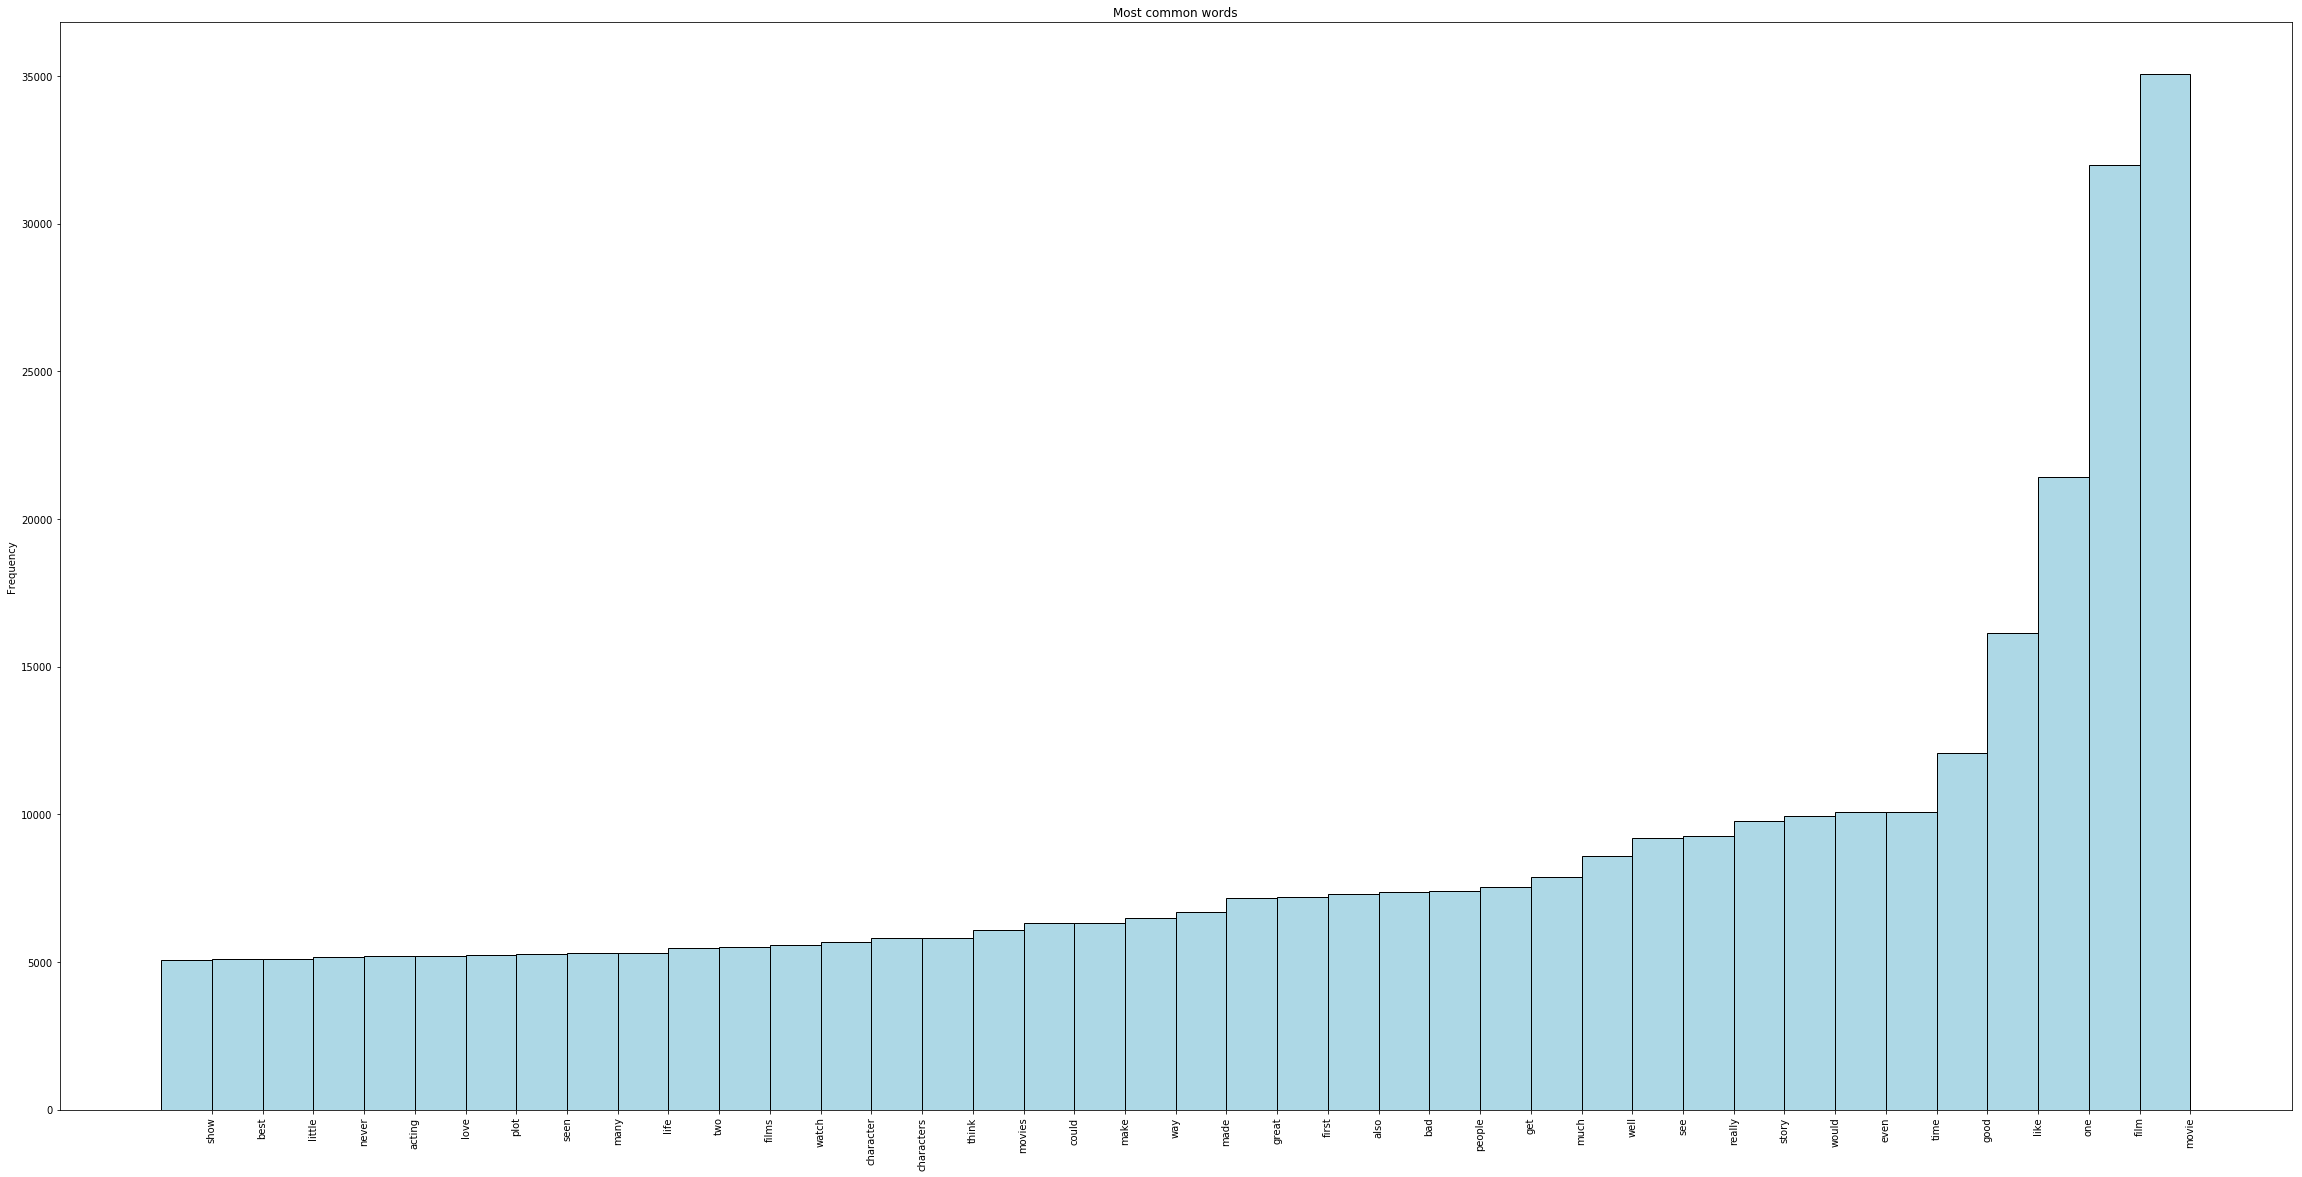

In [124]:
# Plot with most common words
pos = np.arange(len(common_words.frequency))
width = 1.0
ax = plt.axes()
ax.set_xticks(pos + (width / 2))
ax.set_xticklabels(common_words.word)
ax.set_ylabel('Frequency')
ax.set_title("Most common words")
plot = plt.bar(pos, common_words.frequency, width, color = "lightblue", edgecolor='black')
plt.xticks(rotation=90)
plt.rcParams["figure.figsize"] = [20,10]
plt.show




## Supervised Learning Model

We now have a numeric representation of the train data. We can do supervised learning to predict sentiment labels! 

We will start with a <a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html">random forest classifier</a> included in the scikit-learn package. Random forests is a supervised learning algorithm that can be used for both classification and regression problems. 

The inputs to the model will be the data features (X) and the sentiment (Y). We will fit the model to tha data using our train dataset and then test it on our train subset.

### Train model

In [47]:
# Initialize a Random Forest classifier with 100 trees
forest = RandomForestClassifier(n_estimators = 100, random_state = 736438) # more trees is better but will take longer to run

# Fit the forest to the training data
forest = forest.fit(train_data_features, train["sentiment"])

### Test model

We will need to prepare the test data just like we did with the train dataset

In [48]:
# Create an empty list and append the clean reviews
num_reviews = len(test["review"])
clean_test_reviews = [] 

# Loop over reviews and clean each one; append into empty list
for i in range(0,num_reviews):
    clean_test_reviews.append(prepare_words(test["review"][i]))

# Get a bag of words for the test set, and convert to a numpy array
test_data_features = vectorizer.transform(clean_test_reviews)
test_data_features = test_data_features.toarray()

In [50]:
# Use the random forest to make sentiment label predictions
result = forest.predict(test_data_features)

In [51]:
# Look at accuracy of the model at predicting sentiment
correct = np.array(test["sentiment"] == result) # Count number of accurate predictions
accuracy = (np.sum(correct)/test["sentiment"].size)*100 # Percent accurate
print("Accuracy:", round(accuracy,2), "%")

Accuracy: 82.38 %


In [129]:
# Copy the results to the test dataframe
test['prediction'] = result

# Export into a comma-separated output file
test.to_csv("Bag_of_Words_model.csv", index=False)

In [192]:
# Final output
test[0:15]

,index,id,sentiment,review,prediction
0,23250,"""6225_1""",0,"""I doubt this will ever even be a cult film. I...",0
1,3873,"""11465_7""",1,"""This film is scary because you can find yours...",1
2,2456,"""8879_4""",0,"""I think Cliff Robertson certainly was one of ...",0
3,9054,"""12115_4""",0,"""I've been working my way through a collection...",1
4,3924,"""2945_1""",0,"""I watched this movie when Joe Bob Briggs host...",0
5,20438,"""1304_7""",1,"""Okay. Yes, this was a very-tight-budget movie...",1
6,23208,"""611_10""",1,"""I contend that whoever is ultimately responsi...",1
7,6364,"""8878_9""",1,"""This movie had lots of great actors and actre...",1
8,5723,"""11254_1""",0,"""\""Sky Captain and the World of Tomorrow\"" (an...",0
9,6944,"""4734_2""",0,"""You like beautiful girls? Yeah me too. What i...",0


In [189]:
# False positives
false_pos = test['review'][(test["sentiment"] == 0) & (test["prediction"] == 1)]
# False negatives
false_neg = test['review'][(test["sentiment"] == 1) & (test["prediction"] == 0)]

In [190]:
# Let's count the number of false positive and false negatives 
print(false_pos.count())
print(false_neg.count())

431
450


In [187]:
# Let's look at one review - false positive
test['review'][3]

'"I\'ve been working my way through a collection of Lugosi films recently, and having just been blown away a couple of days ago by the combination of Lugosi and Boris Karloff in \\"The Black Cat\\" I was really looking forward to seeing their collaboration in \\"The Raven.\\" Alas, it just didn\'t work for me, and by the end of the film I was quite disappointed.<br /><br />For the first three quarters of this movie or so I thought the story lacked any real suspense. Lugosi was doing a pretty good job of holding things together as the somewhat mad Dr. Vollins, some sort of surgical genius who falls in love with a young woman (Irene Ware) he treats after a car accident but who can\'t have her - partly because she\'s already engaged, and partly because her father (Samuel S. Hinds) disapproves. To deal with that situation, he enlists the aid of Edmond Bateman (Boris Karloff) - a horribly ugly man who wants Vollins to make him look more acceptable. Aside from Lugosi\'s performance, though, 